## Library Included:

In [1]:
import tensorflow as tf
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np

## Load data

In [2]:
# load 
x_data = datasets.load_iris().data    # .data返回iris数据集所有输入特征
y_data = datasets.load_iris().target    # .target返回iris数据集所有标签


from pandas import DataFrame
import pandas as pd

x_data_show = DataFrame(x_data, columns=['花萼长度', '花萼宽度', '花瓣长度', '花瓣宽度'])    # 为表格增加行索引（左侧）和列标签（上方）
pd.set_option('display.unicode.east_asian_width', True)  # 设置列名对齐

x_data_show['类别'] = y_data    # 新加一列，列标签为‘类别’，数据为y_data，此处y_data已经融合在x_data_show中
print("x_data add a column: \n", x_data_show)

x_data add a column: 
      花萼长度  花萼宽度  花瓣长度  花瓣宽度  类别
0         5.1       3.5       1.4       0.2     0
1         4.9       3.0       1.4       0.2     0
2         4.7       3.2       1.3       0.2     0
3         4.6       3.1       1.5       0.2     0
4         5.0       3.6       1.4       0.2     0
..        ...       ...       ...       ...   ...
145       6.7       3.0       5.2       2.3     2
146       6.3       2.5       5.0       1.9     2
147       6.5       3.0       5.2       2.0     2
148       6.2       3.4       5.4       2.3     2
149       5.9       3.0       5.1       1.8     2

[150 rows x 5 columns]


## Dataset shuffle

In [3]:
# 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(116)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

## Generate training set and testing set
First 120 are for training, last 30 are for testing.

In [4]:
# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

## Type cast (optional)

In [5]:
# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

## Group datasets into batches
Group datasets into batches, and feed to the model in the unit of batch.

In [6]:
# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## Construct weights and bias
Set up the neural network by creating all the weight and bias used in the network.

In [7]:
# 生成神经网络的参数，4个输入特征，故输入层为4个输入节点；因为3个分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

## Construct parameters and storage list

In [1]:
lr = 0.1    # 学习率为0.1
train_loss_results = []    # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = []    # 将每轮的accuracy记录在此列表中，为后续画accuracy曲线提供数据
epoch = 500    # 循环500轮
loss_all = 0    # 每轮分4个step，loss_all记录四个step生成的4个loss的和

## Construct neural network
We will loop for 500 times. In each time, we first training the network, then test it immediately. We will also collect 500 loss data and accuracy data.

In [9]:
for epoch in range(epoch):  #数据集级别的循环，每个epoch循环一次数据集
    
    for step, (x_train, y_train) in enumerate(train_db):  #batch级别的循环 ，每个step循环一个batch
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1  # 神经网络乘加运算
            y = tf.nn.softmax(y)  # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将目标标签值转换为独热码格式，方便计算loss和accuracy，e.g.: [1, 0, 0], [0, 1, 0]...
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])

        # 实现梯度更新 w1 = w1 - lr * w1_grad    b = b - lr * b_grad
        w1.assign_sub(lr * grads[0])  # 参数w1自更新
        b1.assign_sub(lr * grads[1])  # 参数b自更新

    # 每个epoch，打印loss信息
    # print("Epoch {}, loss: {}".format(epoch, loss_all/4))
    train_loss_results.append(loss_all / 4)  # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备
    
    
    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
        # 将pred转换为y_test的数据类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        
        # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        # 将每个batch的correct数加起来
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct数加起来
        total_correct += int(correct)
        # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    # print("Test_acc:", acc)
    # print("--------------------------")
print('finished')

finished


## Show the result in graph

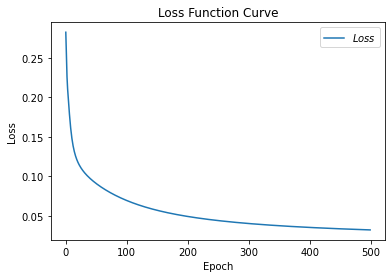

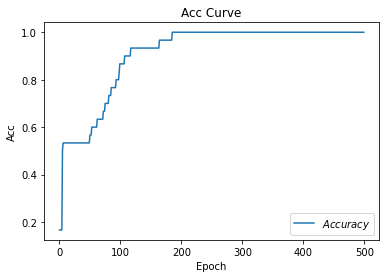

In [10]:
# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()